# ConvNet Abstraction

## Overview

In [116]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
import os
import sys
from typing import Tuple

from dataclasses import dataclass

if '' in sys.path:
    sys.path.remove('')

module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)

print(sys.path)

import networkx as nx

from graphPlot import drawGraph
from const import *

plt.rcParams['figure.figsize'] = [10, 10]
print(plt.rcParams['figure.figsize'])

['/home/shared/anaconda3/lib/python36.zip', '/home/shared/anaconda3/lib/python3.6', '/home/shared/anaconda3/lib/python3.6/lib-dynload', '/home/peng/.local/lib/python3.6/site-packages', '/home/shared/anaconda3/lib/python3.6/site-packages', '/home/shared/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/home/peng/.ipython', '/home/peng/git/convnet-abstraction/python']
[10.0, 10.0]


## DataAugmentation

Let's do a small experiment, here is an augmentation in python

In [118]:

import aug2conv
from mxnet.ndarray import NDArray
from mxnet.gluon.data import DataLoader
from mxnet.gluon.nn import Sequential

data = aug2conv.getData()

imgs: NDArray
imgs, ls = next(data.__iter__())

(10, 10)


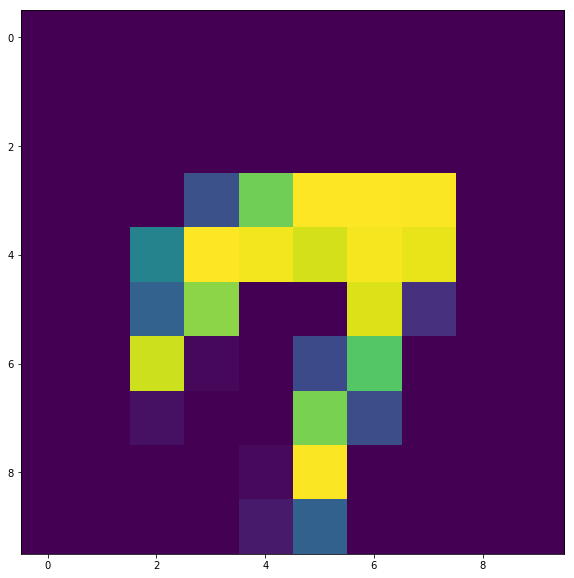

In [119]:
img1 = imgs[0].squeeze(axis=(0,))
print(img1.shape)
plt.imshow(img1.asnumpy())

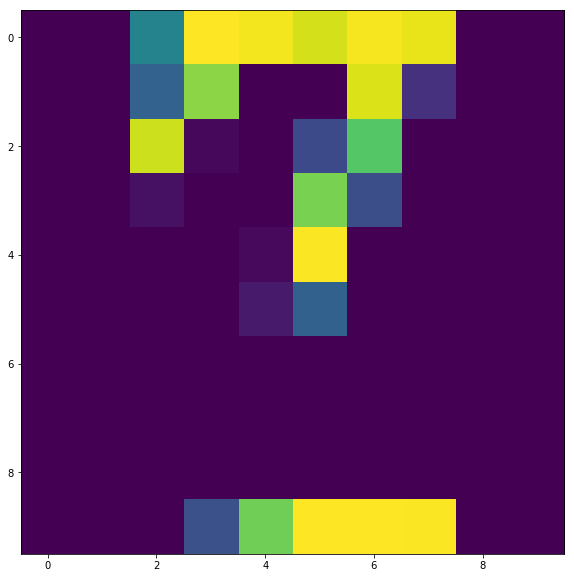

In [ ]:

auged = img1.copy()

auged = aug2conv.shiftY(auged, 6)
plt.imshow(auged.asnumpy())

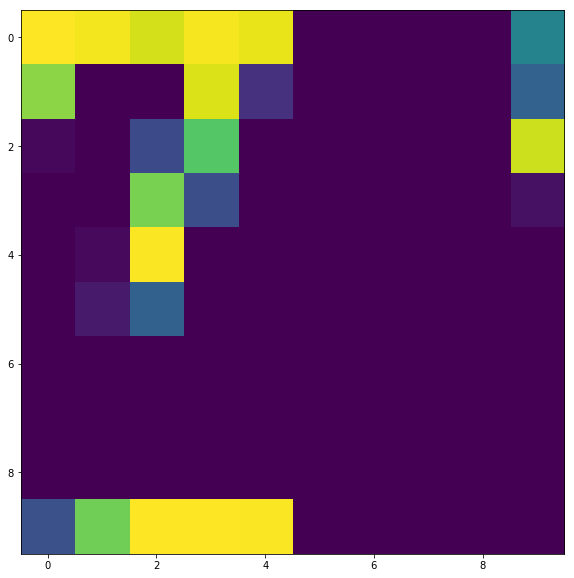

In [ ]:
auged = aug2conv.shiftX(auged, 7)
plt.imshow(auged.asnumpy())

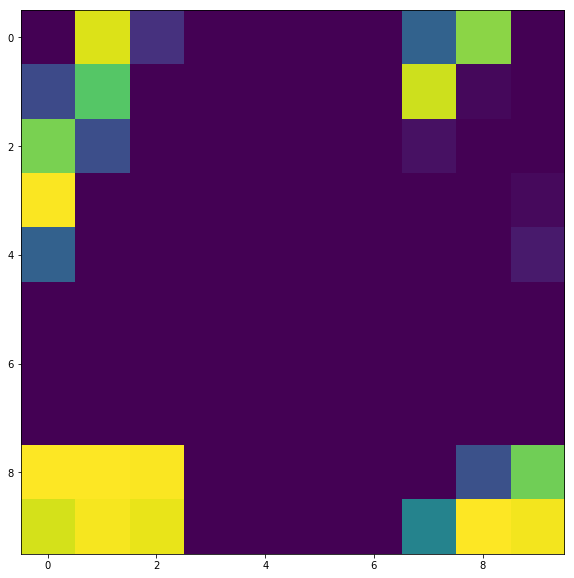

In [ ]:
augmenter = aug2conv.Augmenter(img1)
auggedUp = augmenter.aug1(img1)
plt.imshow(auggedUp[55, :, :].asnumpy())

In [ ]:

from mxnet import autograd, initializer
import mxnet.gluon as glu
from pathlib import Path

lossFn = glu.loss.SoftmaxCrossEntropyLoss()

In [ ]:

@dataclass
class HWY(glu.HybridBlock):

    def __init__(self, layers: Tuple):
        super(HWY, self).__init__()
        self.delegate = glu.nn.HybridSequential()
        self.delegate.add(*layers)

    def getLayers(self):
        return list(self.delegate)

    def hybrid_forward(self, F, x, *args, **kwargs):
        r = self.delegate.forward(x, *args)
        return r + x.reshape(r.shape)

    def __hash__(self):
        return hash(self.delegate)

In [ ]:
# Build a feed-forward network
def newModel() -> glu.nn.HybridSequential:
    model = glu.nn.HybridSequential()
    # with model.name_scope():
    model.add(
        HWY((
            glu.nn.Dense(100),
            glu.nn.Activation('relu')
        )),
        HWY((
            glu.nn.Dense(100),
            glu.nn.Activation('relu')
        )),
        glu.nn.Dense(10)
    )

    model.initialize(ctx=CTX)
    return model

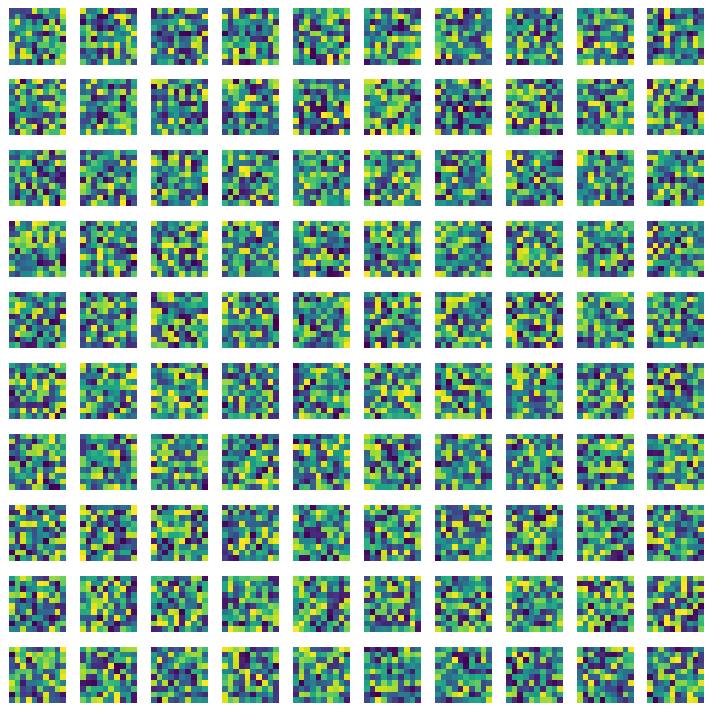

In [ ]:

import utils.helper

model = newModel()
model.forward(imgs.as_in_context(CTX))

fc1 = model[0].getLayers()[0]
utils.helper.viewFCWeights(fc1)

In [ ]:
def train(
        name: str,
        loader: DataLoader = data,
        lossTarget=0.15,
        maxEpochs=50,
        aug=lambda v: v
) -> Sequential:
    model = newModel()

    filePath = f"{os.getcwd()}/{MODEL_CHKPNT}/{name}.model"

    try:
        model.load_parameters(filePath)
        print(f">> model loaded from: {filePath}")
    except Exception as ee:
        print(f">> model being learned from scratch: {filePath}")

        optimizer = glu.Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.01})

        # cc = 0
        for epoch in range(maxEpochs):
            sumLoss = 0
            for imgs, labels in loader:
                # print(f"loading batch {cc} - of {imgs.shape[0]}")
                # cc += 1
                imgs = imgs.squeeze(axis=(1,))

                imgs, labels = aug((imgs, labels))
                imgs = imgs.as_in_context(CTX)
                labels = labels.as_in_context(CTX)

                with autograd.record():
                    output = model.forward(imgs)
                    loss = lossFn(output, labels)

                loss.backward()
                sumLoss += loss.mean().asscalar()

                optimizer.step(imgs.shape[0] / 2)

            else:
                print(f"Training loss: {sumLoss / len(loader)}")

            if sumLoss / len(loader) <= lossTarget:
                break

        os.makedirs(Path(filePath).parent, exist_ok=True)
        model.save_parameters(filePath)
        print(f">>> model saved to: {filePath}")

    return model

>> model being learned from scratch: /home/peng/git/convnet-abstraction/slide/.model_checkpoints/raw.model
Training loss: 0.763373378306818
Training loss: 0.4197192313447436
Training loss: 0.3740949473782643
Training loss: 0.34292855282931695
Training loss: 0.3156888134984065
Training loss: 0.2912937805000971
Training loss: 0.2698382562332189
Training loss: 0.2513936551641236
Training loss: 0.23513728193938732
Training loss: 0.2212246386235012
Training loss: 0.20870970254307236
Training loss: 0.19860618237032693
Training loss: 0.18885318443639829
Training loss: 0.1799863337048653
Training loss: 0.17242732559884788
Training loss: 0.16542735894018018
Training loss: 0.15869482312160832
Training loss: 0.15263750463096634
Training loss: 0.1479089778484598
>>> model saved to: /home/peng/git/convnet-abstraction/slide/.model_checkpoints/raw.model


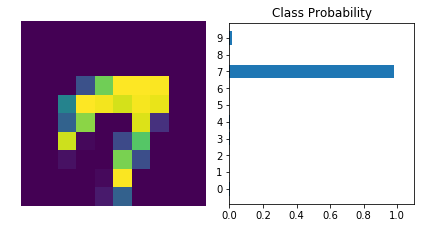

In [ ]:

model = train("raw")

logits = model.forward(imgs.as_in_context(CTX))
ps = mx.ndarray.softmax(logits, axis=1)

utils.helper.view_classify(imgs[0], ps[0])

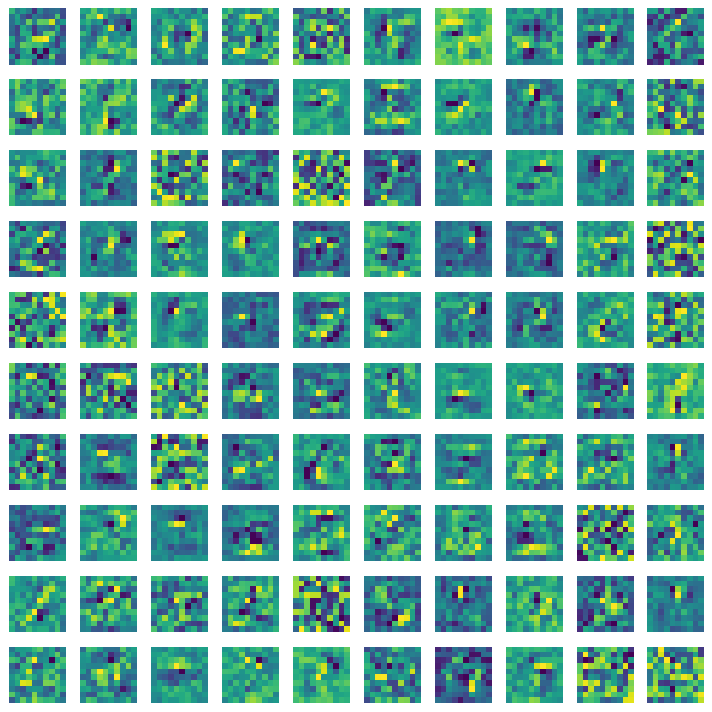

In [ ]:

fc1 = model[0].getLayers()[0]
utils.helper.viewFCWeights(fc1)

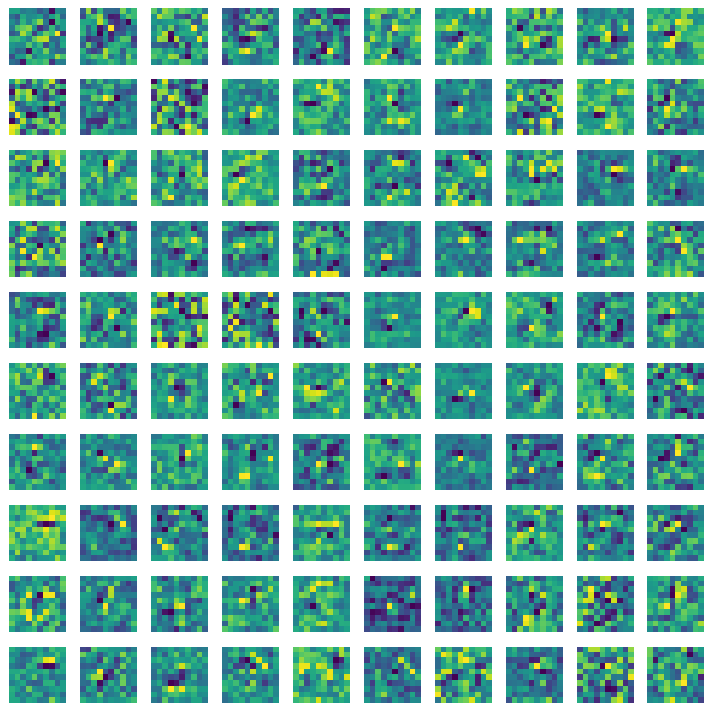

In [ ]:

fc2 = model[1].getLayers()[0]
utils.helper.viewFCWeights(fc2)

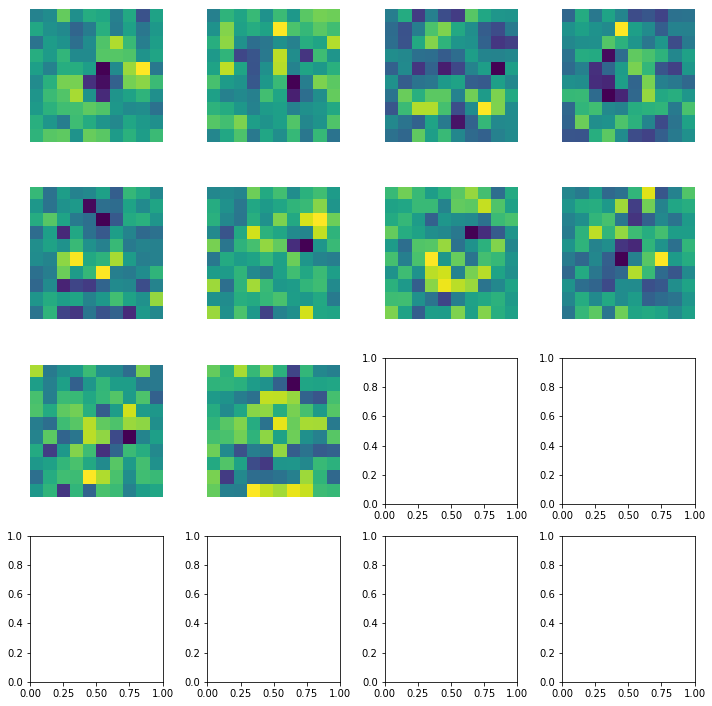

In [ ]:

fc3 = model[2]
utils.helper.viewFCWeights(fc3)

In [ ]:

# now let's enable augmentation

augModel = train("aug", aug=augmenter.augFirstTuple)

>> model being learned from scratch: /home/peng/git/convnet-abstraction/slide/.model_checkpoints/aug.model
Training loss: 2.3252444110318287
Training loss: 2.2482636456550567
Training loss: 2.213096148773297
Training loss: 2.1370400563041283
Training loss: 2.0916431092821965
Training loss: 1.976335191527314
Training loss: 1.8340025915583569
Training loss: 1.7727783040514886
Training loss: 1.703682544404891
Training loss: 1.6119378179009916
Training loss: 1.674338880203553
Training loss: 1.5925658074046758
Training loss: 1.536300160078161
Training loss: 1.4340165099069508
Training loss: 1.4715408037172388
Training loss: 1.3411719464559926
Training loss: 1.3212721621089463
Training loss: 1.2380978217286898
Training loss: 1.1980327362887688


In [ ]:

fc1 = augModel[0].getLayers()[0]
utils.helper.viewFCWeights(fc1)

In [ ]:

fc2 = augModel[1].getLayers()[0]
utils.helper.viewFCWeights(fc2)

In [ ]:

fc3 = augModel[2]
utils.helper.viewFCWeights(fc3)